# Una red neuronal convolucional para detectar objetos

In [1]:
import os 
import sys
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from six.moves import urllib
session = tf.Session()

In [2]:
batch_size = 128
output_every = 50
generations = 20000
eval_every = 500
image_height = 32
image_width = 32
crop_height = 24
crop_width = 24
num_channels = 3
num_targets = 10
data_folder = "cifar-10-batches-bin"

$$learning\ rate = 0.1\cdot 0.9^{\frac{x}{250}}$$

In [3]:
learning_rate = 0.1
lr_decay = 0.9
num_gens_to_wait = 250

In [4]:
image_vect_length = image_height*image_width*num_channels
record_length = 1+image_vect_length

### Descarga y procesamiento de CIFAR 10

In [5]:
data_dir = 'cifar-10-temp'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
cifar10_url = "http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz"
data_file = os.path.join(data_dir, 'cifar-10-binary.tar.gz')
if not os.path.isfile(data_file):
    filepath, _ = urllib.request.urlretrieve(cifar10_url, data_file)
    tarfile.open(filepath, 'r:gz').extractall(data_dir)

In [6]:
def read_cifar_files(filename_queue, distort_images = True):
    reader = tf.FixedLengthRecordReader(record_bytes=record_length)
    key, record_string = reader.read(filename_queue)
    #creamos fichero binario
    record_bytes = tf.decode_raw(record_string, tf.uint8)
    #extraemos la etiqueta
    image_label = tf.cast(tf.slice(record_bytes, [0], [1]), tf.int32)
    #extraemos la imagen
    image_extracted = tf.reshape(tf.slice(record_bytes, [1], [image_vect_length]), [num_channels, image_height, image_width])
    #redimensión de imagen
    reshaped_image = tf.transpose(image_extracted, [1,2,0])
    reshaped_image = tf.cast(reshaped_image, tf.float32)
    #crop aleatorio
    final_image = tf.image.resize_image_with_crop_or_pad(reshaped_image, crop_width, crop_height)
    if distort_images:
        #flip aleatorio horizontal, cambiar brillo y contraste
        final_image = tf.image.random_flip_left_right(final_image)
        final_image = tf.image.random_brightness(final_image, max_delta=63)
        final_image = tf.image.random_contrast(final_image, lower=0.2, upper=1.8)
    #estandarización por color
    final_image = tf.image.per_image_standardization(final_image)
    return final_image, image_label

In [7]:
def input_pipeline(batch_size, train_logical=True):
    if train_logical:
        files = [os.path.join(data_dir, data_folder, 'data_batch_{}.bin'.format(i)) for i in range(1,6)]
    else:
        files = [os.path.join(data_dir, data_folder, 'test_batch.bin')]
    
    filename_queue = tf.train.string_input_producer(files)
    image, label = read_cifar_files(filename_queue)
    
    min_after_dequeue = 1000
    capacity = min_after_dequeue+3*batch_size
    example_batch, label_batch = tf.train.shuffle_batch([image,label], batch_size, capacity, min_after_dequeue)
    return example_batch, label_batch

In [8]:
def cifar_cnn_model(input_images, batch_size, train_logical=True):
    def truncated_normal_var(name, shape, dtype):
        return tf.get_variable(name=name, shape=shape, dtype=dtype, 
                               initializer=tf.truncated_normal_initializer(stddev=0.05))
    def zero_var(name, shape, dtype):
        return tf.get_variable(name=name, shape=shape, dtype=dtype, 
                              initializer=tf.constant_initializer(0.0))
    
    
    ## Primera capa de convolución
    with tf.variable_scope("conv1") as scope:
        # conv con kernel 5x5 para 3 canales con un total de 64 nodos de salida
        conv1_kernel = truncated_normal_var(name="conv_lernel1", shape=[5,5,3,64], dtype=tf.float32)
        conv1 = tf.nn.conv2d(input_images, conv1_kernel, [1,1,1,1],padding="SAME")
        conv1_bias = zero_var(name="conv_bias1", shape=[64], dtype=tf.float32)
        conv1_add_bias = tf.nn.bias_add(conv1, conv1_bias)
        ## Capa de relu
        relu_conv1 = tf.nn.relu(conv1_add_bias)
    # capa de max pooling  con ventana de 3x3 que se mueve de a 2 lugares cada vez 
    pool1 = tf.nn.max_pool(relu_conv1, ksize=[1,3,3,1], strides=[1,2,2,1],padding="SAME", name="pool_layer1")
    
    # normalizacion local (en ingles: local response normalization(lrn)) sirve para normalizar las imagenes.
    norm1 = tf.nn.lrn(pool1, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name="norm1")
    
    
    
    ## Segunda capa de convolución
    with tf.variable_scope("conv2") as scope:
        # conv con kernel 5x5 para 64 nodos de entrada con un total de 64 nodos de salida
        conv2_kernel = truncated_normal_var(name="conv_lernel2", shape=[5,5,64,64], dtype=tf.float32)
        conv2 = tf.nn.conv2d(norm1, conv2_kernel, [1,1,1,1],padding="SAME")
        conv2_bias = zero_var(name="conv_bias2", shape=[64], dtype=tf.float32)
        conv2_add_bias = tf.nn.bias_add(conv2, conv2_bias)
        ## Capa de relu
        relu_conv2 = tf.nn.relu(conv2_add_bias)
    # capa de max pooling  con ventana de 3x3 que se mueve de a 2 lugares cada vez
    pool2 = tf.nn.max_pool(relu_conv2, ksize=[1,3,3,1], strides=[1,2,2,1],padding="SAME", name="pool_layer2")
    
    # normalizacion local (en ingles: local response normalization(lrn)) sirve para normalizar las imagenes.
    norm2 = tf.nn.lrn(pool2, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name="norm2")
    
    #Redimensionar a una matriz para poder multiplicar en las capas totalmente conectadas
    reshaped_output = tf.reshape(norm2, [batch_size,-1])
    reshaped_dim = reshaped_output.get_shape()[1].value
    
    
    
    # primera capa totalmente conectada con la cantidad de nodos de entrada que devuleva"reshaped_dim" y con 384 nodos de salida
    with tf.variable_scope("full1") as scope:
        #Full connected con 384 nodos
        full_weight1 = truncated_normal_var(name="full_mult1", shape=[reshaped_dim, 384], dtype = tf.float32)
        full_bias1 = zero_var(name="full_bias1", shape=[384], dtype=tf.float32)
        full_layer1 = tf.nn.relu(tf.add(tf.matmul(reshaped_output, full_weight1), full_bias1))
    # segunda capa totalmente conectada con 384 nodos de entrada y con 192 nodos de salida
    with tf.variable_scope("full2") as scope:
        #Full connected con 192 nodos
        full_weight2 = truncated_normal_var(name="full_mult2", shape=[384, 192], dtype = tf.float32)
        full_bias2 = zero_var(name="full_bias2", shape=[192], dtype=tf.float32)
        full_layer2 = tf.nn.relu(tf.add(tf.matmul(full_layer1, full_weight2), full_bias2))
    # tercera capa totalmente conectada con 192 nodos de entrada y con 10 nodos de salida (num_targets=10)
    with tf.variable_scope("full3") as scope:
        #Full connected con una de las 10 categorías de salida
        full_weight3 = truncated_normal_var(name="full_mult3", shape=[192, num_targets], dtype = tf.float32)
        full_bias3 = zero_var(name="full_bias3", shape=[num_targets], dtype=tf.float32)
        final_output = tf.add(tf.matmul(full_layer2, full_weight3), full_bias3)
    
    return final_output

In [9]:
def cifar_loss(logits, targets):
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets)
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    return cross_entropy_mean

In [10]:
def train_step(loss_value, generation_num):
    model_learning_rate = tf.train.exponential_decay(learning_rate, generation_num, 
                                                     num_gens_to_wait, lr_decay, staircase=True)
    my_optim = tf.train.GradientDescentOptimizer(model_learning_rate)
    train_step = my_optim.minimize(loss_value)
    return train_step

In [11]:
def accuracy_from_batches(logits, targets):
    targets = tf.squeeze(tf.cast(targets, tf.int32)) #elimino las dimensiones inecesarias con squeeze
    batch_predictions = tf.cast(tf.argmax(logits,1), tf.int32) # los logits contienen probabilidades de los targets, con "tf.argmax" seleccionamos la mas alta
    predicted_correctly = tf.equal(batch_predictions, targets) # compara predicciones contra targets, coloca V en caso de ser iguales y F en caso de ser distintas, y las va almacenando.
    accuracy = tf.reduce_mean(tf.cast(predicted_correctly, tf.float32)) # convertimos los V a 1 y los F a 0, y hacemos el promedio
    return accuracy

### Entrenamiento

In [12]:
images, targets = input_pipeline(batch_size, train_logical=True)
test_images, test_targets = input_pipeline(batch_size, train_logical=False)

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.FixedLe

In [13]:
with tf.variable_scope('model_definition') as scope:
    model_output = cifar_cnn_model(images, batch_size)
    scope.reuse_variables()
    test_output = cifar_cnn_model(test_images, batch_size)

In [14]:
loss = cifar_loss(model_output, targets)
accuracy = accuracy_from_batches(test_output, test_targets)
generation_num = tf.Variable(0, trainable=False)
train_op = train_step(loss, generation_num)

In [15]:
init = tf.global_variables_initializer()
session.run(init)

In [16]:
tf.train.start_queue_runners(sess=session)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.


[<Thread(QueueRunnerThread-input_producer-input_producer/input_producer_EnqueueMany, started daemon 6708)>,
 <Thread(QueueRunnerThread-shuffle_batch/random_shuffle_queue-shuffle_batch/random_shuffle_queue_enqueue, started daemon 8632)>,
 <Thread(QueueRunnerThread-input_producer_1-input_producer_1/input_producer_1_EnqueueMany, started daemon 312)>,
 <Thread(QueueRunnerThread-shuffle_batch_1/random_shuffle_queue-shuffle_batch_1/random_shuffle_queue_enqueue, started daemon 6680)>]

In [17]:
train_loss = []
test_acc = []
for i in range(10):
    _, loss_value = session.run([train_op, loss])
    if (i+1) % 1 == 0:
        train_loss.append(loss_value)
        print("Paso {}, Pérdida: {:.5f}".format((i+1),loss_value))
    if (i+1) % 5 == 0:
        [temp_acc] = session.run([accuracy])
        test_acc.append(temp_acc)
        print("--- Precisión en test: {:.2f}%. ---".format(100*temp_acc))

Paso 1, Pérdida: 2.30571
Paso 2, Pérdida: 2.31374
Paso 3, Pérdida: 2.31550
Paso 4, Pérdida: 2.29289
Paso 5, Pérdida: 2.29567
--- Precisión en test: 17.19%. ---
Paso 6, Pérdida: 2.28516
Paso 7, Pérdida: 2.27819
Paso 8, Pérdida: 2.26726
Paso 9, Pérdida: 2.25986
Paso 10, Pérdida: 2.23801
--- Precisión en test: 20.31%. ---


In [19]:
eval_idx = range(0, generations, eval_every)
output_idx = range(0,generations, output_every)

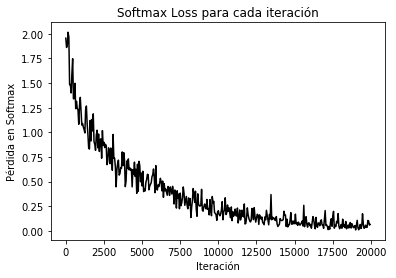

In [21]:
plt.plot(output_idx, train_loss, 'k-')
plt.title("Softmax Loss para cada iteración")
plt.xlabel("Iteración")
plt.ylabel("Pérdida en Softmax")
plt.show()

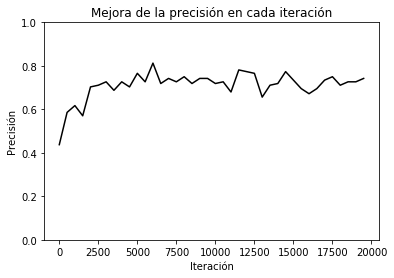

In [23]:
plt.plot(eval_idx, test_acc, 'k-')
plt.title("Mejora de la precisión en cada iteración")
plt.xlabel("Iteración")
plt.ylabel("Precisión")
plt.ylim([0,1])
plt.show()